# Example of study on in-store transactions

The aim of this Notebook is to give an example of analysis we can lead on transaction data.

The dataset was given to me during a challenge. It contains a list of transactions in different supermarkets. It is not extracted from real transactions but simulated under realistic assumptions.

It contains the value of the transaction in $, the gender of the customer and the type of store.

In [7]:
%matplotlib inline
import pandas as pd
from numpy import log10
import matplotlib.pyplot as plt
import scipy.stats as stats

In [10]:
trans = pd.read_csv("./input/transactions.tsv", sep='\t')

In [11]:
trans.columns.tolist()

['transaction.value', 'gender', 'store.type']

In [12]:
trans.columns = ['value', 'gender', 'store']
trans.head()

,value,gender,store
0,33.80,Male,type1
1,7.02,Male,type2
2,335.88,Female,type3
3,79.02,Male,type2
4,354.15,Male,type1


In [13]:
print('Number of transactions: {}'.format(trans.value.count()))
print('Average transaction value: {} $'.format(int(trans.value.mean())))
print('Different store types: {}'.format(trans.store.unique().tolist()))
print('Genders: {}'.format(trans.gender.unique().tolist()))

Number of transactions: 2000
Average transaction value: 286 $
Different store types: ['type1', 'type2', 'type3', 'type4']
Genders: ['Male', 'Female']


There are 2000 transactions. The data seems quite clean (there are no weird store type or weird gender neither).

Let's see if there are any differences between male and female transaction values.

In [14]:
male = trans[trans.gender=='Male']
female = trans[trans.gender=='Female']

In [15]:
pd.DataFrame({'male':male.value.describe(), 'female': female.value.describe()})

,female,male
count,986.000000,1014.000000
mean,427.234260,149.012939
std,5749.744757,263.323544
min,2.590000,0.460000
25%,25.472500,19.910000
50%,51.990000,42.785000
75%,192.180000,158.420000
max,150032.000000,3180.760000


At first sight the transactions seem quite different between males and females. The average female transaction value is almost 3 times bigger than the male one. The standard deviation of female transaction values is also huge compared to the male one.

Lets plot the histogram of these values. For more readibility we use the log10 of transaction values.

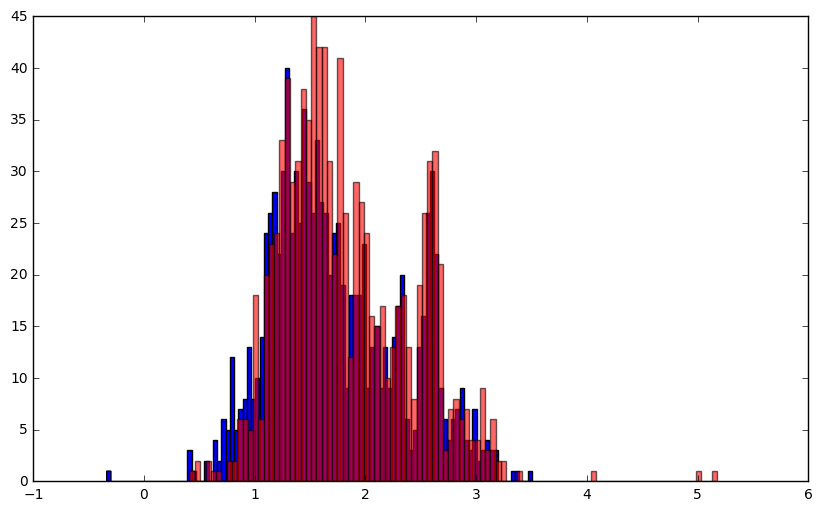

In [17]:
plt.figure(figsize=(10,6))
plt.hist(log10(male.value), bins=100)
plt.hist(log10(female.value), bins=100, color='red', alpha=0.6)
plt.show()

It appears clearly that we have 3 outliers in our data that can explain the big difference we have between female and male transaction values.

These outliers are superior to 10 000$. It is exceptional for transactions in a supermarket. Either the customers bought very expensive products like household appliances, or there were mistakes in the data collection.

However it is more meaningful to drop these outliers in order to lead a better analysis on female and male transaction values.

In [19]:
female = female[female.value<10000]
pd.DataFrame({'male':male.value.describe(), 'female': female.value.describe()})

,female,male
count,983.000000,1014.000000
mean,162.137060,149.012939
std,263.168334,263.323544
min,2.590000,0.460000
25%,25.385000,19.910000
50%,51.620000,42.785000
75%,188.050000,158.420000
max,2502.390000,3180.760000


The values seem much more similar now! Standard deviations are the same. Mean values are slightly different.

Let's perform a statistical test to check this point.

In [20]:
# T-test for equal means : null Hypothesis=same mean
t, p = stats.ttest_ind(male.value, female.value, axis=0, equal_var=True)
print(round(p, 2))

0.27


p-value equals 27% which is much more than 5%.

We can't reject the null-hypothesis so we can assume that the average female and male transaction value is the same.

Let's study the different store types now.

In [21]:
trans = trans[trans.value<10000]
t1 = trans[trans.store=='type1']
t2 = trans[trans.store=='type2']
t3 = trans[trans.store=='type3']
t4 = trans[trans.store=='type4']
pd.DataFrame({'type 1':t1.value.describe(),'type 2':t2.value.describe(),
              'type 3':t3.value.describe(),'type 4':t4.value.describe()})

,type 1,type 2,type 3,type 4
count,486.000000,829.000000,400.000000,282.000000
mean,113.176605,155.166490,256.231125,86.349468
std,218.942121,215.615642,387.696657,191.863120
min,2.750000,3.140000,0.460000,5.130000
25%,16.657500,34.390000,32.962500,15.395000
50%,27.745000,71.500000,109.885000,25.795000
75%,53.477500,177.460000,335.950000,41.242500
max,1569.600000,1479.890000,3180.760000,1436.020000


The 4 types have similarities and differences.

Regarding the mean: they all look very different from each other.

Regarding the standard deviation: type 1 and type 2 look similar.

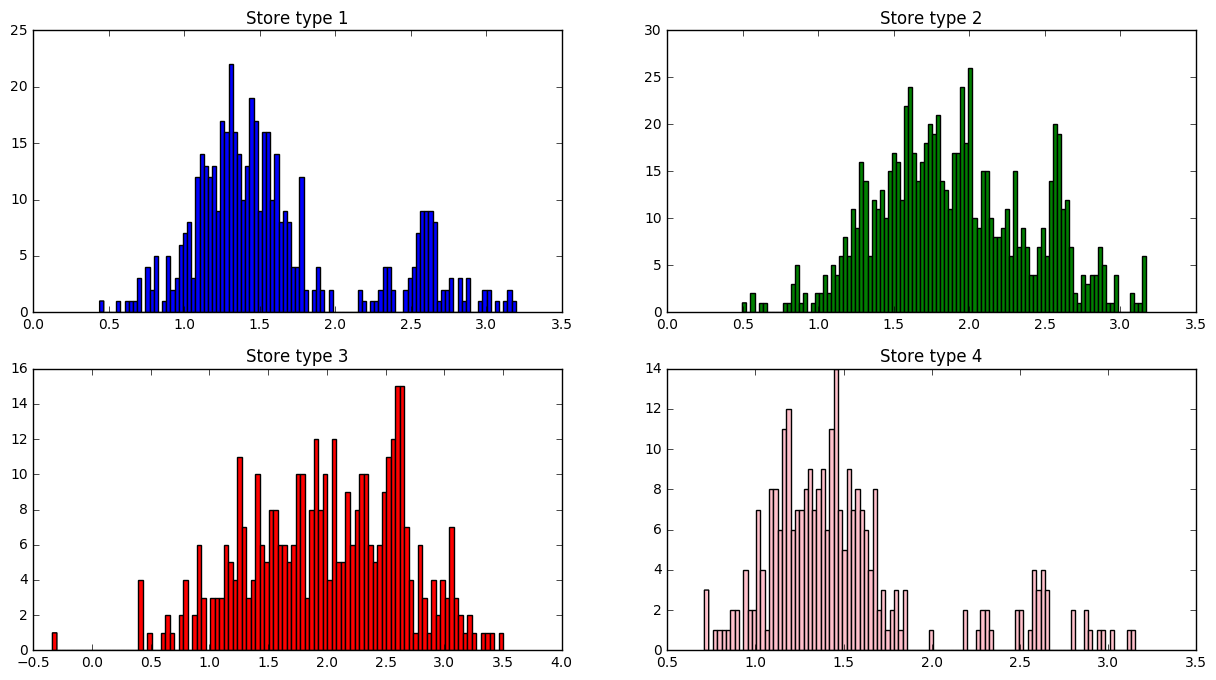

In [22]:
plt.figure(figsize=(15, 8))
plt.subplot(221, title='Store type 1')
plt.hist(log10(t1.value), bins=100, color='blue')
plt.subplot(222, title='Store type 2')
plt.hist(log10(t2.value), bins=100, color='green')
plt.subplot(223, title='Store type 3')
plt.hist(log10(t3.value), bins=100, color='red')
plt.subplot(224, title='Store type 4')
plt.hist(log10(t4.value), bins=100, color='pink')
plt.show()

When looking at these histograms it appears that store type 1 and store type 3 have similar distributions.
The 2 other store types have different distributions.

Let's perform statistical tests on the means and standard deviations to see what we can say about means and variances.

In [23]:
# Bartlett’s test for equal variances : null Hypothesis=same variance
t12, p12 = stats.bartlett(t1.value, t2.value)
t13, p13 = stats.bartlett(t1.value, t3.value)
t14, p14 = stats.bartlett(t1.value, t4.value)
t23, p23 = stats.bartlett(t2.value, t3.value)
t24, p24 = stats.bartlett(t2.value, t4.value)
t34, p34 = stats.bartlett(t3.value, t4.value)
[p12, p13, p14, p23, p24, p34] = [round(x, 3) for x in [p12, p13, p14, p23, p24, p34]]
pd.DataFrame([['x', p12, p13, p14], ['x', 'x', p23, p24], ['x', 'x', 'x', p34], ['x', 'x', 'x', 'x']],
             columns=['type 1','type 2','type 3','type 4'], index=['type 1','type 2','type 3','type 4'])

,type 1,type 2,type 3,type 4
type 1,x,0.705,0,0.014
type 2,x,x,0,0.019
type 3,x,x,x,0
type 4,x,x,x,x


With a p-value of 70% we can assume that store type 1 and store type 2 have the same variance.

The 2 other types have different variances.

In [24]:
# T-test for equal means : null Hypothesis=same mean
t12, p12 = stats.ttest_ind(t1.value, t2.value, equal_var=True)
t13, p13 = stats.ttest_ind(t1.value, t3.value, equal_var=False)
t14, p14 = stats.ttest_ind(t1.value, t4.value, equal_var=False)
t23, p23 = stats.ttest_ind(t2.value, t3.value, equal_var=False)
t24, p24 = stats.ttest_ind(t2.value, t4.value, equal_var=False)
t34, p34 = stats.ttest_ind(t3.value, t4.value, equal_var=False)
[p12, p13, p14, p23, p24, p34] = [round(x, 3) for x in [p12, p13, p14, p23, p24, p34]]
pd.DataFrame([['x', p12, p13, p14], ['x', 'x', p23, p24], ['x', 'x', 'x', p34], ['x', 'x', 'x', 'x']],
             columns=['type 1','type 2','type 3','type 4'], index=['type 1','type 2','type 3','type 4'])

,type 1,type 2,type 3,type 4
type 1,x,0.001,0,0.077
type 2,x,x,0,0
type 3,x,x,x,0
type 4,x,x,x,x


Store type 1 and store type 3 have very probably the same mean! It goes on the same way than the observation of the histograms.

The 2 other types have different means.

### Conclusion

This study allowed us first to compare transaction values between males and females. As we saw they are likely to have the same caracteristics! Don't forget to take a look at the data and to drop outliers.

Then we compared different store types. It appears that store type 1 and store type 2 have the same variance but not the same mean.

Store type 1 and store type 3 have the same mean but not the same variance. Maybe the store have the same product but are not located in the same type of places which could explain the difference of variances! If you have another interpretation on these results, feel free to comment :)